In [33]:
# dependencies
from torch.utils.data import DataLoader
from torch import optim 
from torchvision.datasets import ImageFolder
from torchvision import transforms as tvt
from PIL import Image
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
device = 'mps' #  for mac, PC users need change to 'cuda' if they have discrete GPU, else 'cpu'

In [42]:
# intemediate layers of CNN, sandwhiched between input and output
# CNN, BATCH NORM, RELU
class intermediate(nn.Module):
  def __init__(self, K = 3, S = 1, P = 1, F = 16):
    super(intermediate, self).__init__()
    chain = [None] * 3
    chain[0] = nn.Conv2d(in_channels = F, out_channels = F, kernel_size = K, stride = S, padding = P)
    chain[1] = nn.BatchNorm2d(F)
    chain[2] =  nn.ReLU(inplace = True)
    self.trans = nn.Sequential(*chain)
  def forward(self, inp):
    return self.trans(inp)


# create the model
class DENOISER(nn.Module):
  def __init__(self, layers = 64):
    super(DENOISER, self).__init__()
    chain = []
    K, S, P, F = 3, 1, 1, 16
    chain.append(nn.Conv2d(in_channels = 1, out_channels = F, kernel_size = K, stride = S, padding = P))
    chain.append(nn.ReLU(inplace = True))
    for i in range(layers): chain.append(intermediate(K = K, S = S, P = P, F = F))
    chain.append(nn.Conv2d(in_channels = F, out_channels = 1, kernel_size = K, stride = S, padding = P))
    self.trans = nn.Sequential(*chain)
  def forward(self, inp):
    return self.trans(inp) - inp

In [43]:
# hyperparameters
net = DENOISER().to(device)
num_epochs =  5
lr = 1e-3
batch_size = 4
opt = optim.Adam(net.parameters(), lr = lr)
criterion = nn.MSELoss(size_average = False)
noiselvl = 30
alpha = 0.5

/Users/ilanbenschikovski/anaconda3/envs/kak/lib/python3.12/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [26]:
# create toy dataloader
uniform_transform = tvt.Compose([tvt.Grayscale(), tvt.Resize((300, 300)), tvt.ToTensor()])
dataset = ImageFolder(root = 'coco_samples_train', transform = uniform_transform)
dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

In [27]:
for epoch in range(1, num_epochs + 1):
  for idx, (data, _), in enumerate(dataloader):
    raw = data.to(device)
    net.train()
    net.zero_grad()
    opt.zero_grad()
    sigma_norm = noiselvl / 255 # max pixel val
    noise = (torch.randn(raw.shape) * sigma_norm).to(device)

    subnoise = raw - noise
    addnoise = raw + noise

    out = net(subnoise)
    loss = criterion(out, addnoise)
    print(loss)
    loss.backward()
    opt.step()
    net.eval()


tensor(360211.6250, device='mps:0', grad_fn=<MseLossBackward0>)
tensor(374291.5000, device='mps:0', grad_fn=<MseLossBackward0>)
tensor(330598.4688, device='mps:0', grad_fn=<MseLossBackward0>)
tensor(171491.2031, device='mps:0', grad_fn=<MseLossBackward0>)
tensor(443383.4062, device='mps:0', grad_fn=<MseLossBackward0>)
tensor(197395.7500, device='mps:0', grad_fn=<MseLossBackward0>)
tensor(294195.0625, device='mps:0', grad_fn=<MseLossBackward0>)
tensor(263952.2500, device='mps:0', grad_fn=<MseLossBackward0>)
tensor(136067.1094, device='mps:0', grad_fn=<MseLossBackward0>)
tensor(169336.5938, device='mps:0', grad_fn=<MseLossBackward0>)
tensor(116992.5156, device='mps:0', grad_fn=<MseLossBackward0>)
tensor(132629.0625, device='mps:0', grad_fn=<MseLossBackward0>)
tensor(145013.8438, device='mps:0', grad_fn=<MseLossBackward0>)
tensor(115631.6094, device='mps:0', grad_fn=<MseLossBackward0>)
tensor(97290.9141, device='mps:0', grad_fn=<MseLossBackward0>)
tensor(104976.7969, device='mps:0', grad_

In [28]:
# create toy dataloader
uniform_transform = tvt.Compose([tvt.Grayscale(), tvt.Resize((300, 300)), tvt.ToTensor()])
dataset = ImageFolder(root = 'coco_samples_test', transform = uniform_transform)
dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

torch.Size([4, 1, 300, 300])


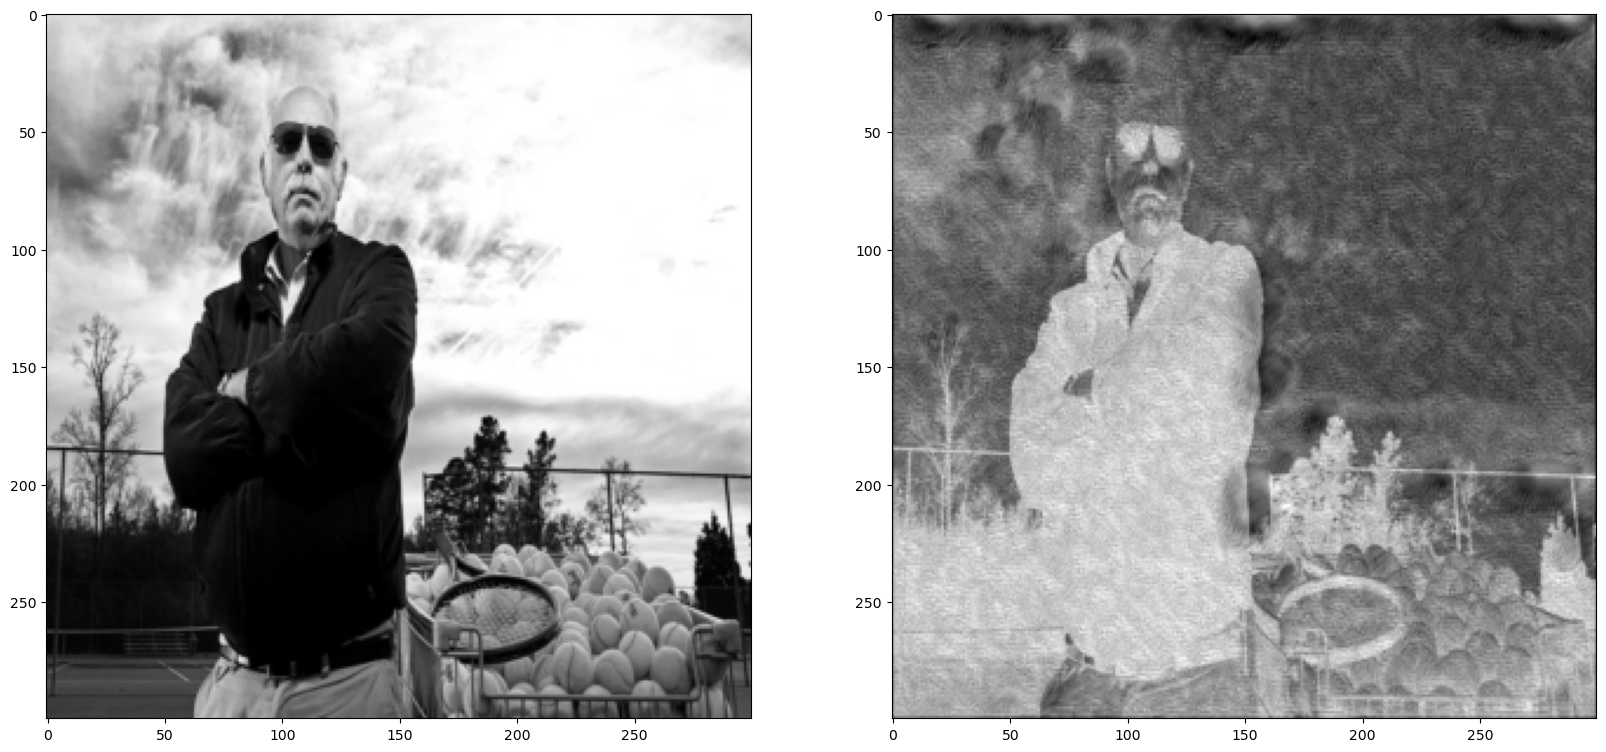

In [31]:
for idx, (data, _), in enumerate(dataloader):
  data = data.to(device)
  out = net(data).to('cpu').detach()
  print(out.shape)
  fig = plt.figure(figsize = (20,50))
  plt.subplot(1,2,1)
  plt.imshow(data.to('cpu')[0].permute(1,2,0), cmap = 'gray')
  plt.subplot(1,2,2)
  plt.imshow(out[0].permute(1,2,0), cmap = 'gray')

  break